## In this notebook, we will go through following topics:

- Feature Engineering
- Neural Network Creation
- Strategy Backtesting

The focus of this lab would be to understand the implementation of neural networks using the scikit-learn library. To do so, we will start with importing necessary libraries.

## Part 1 - Training a neural network

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Apply the default seaborn theme, scaling, and color palette
sns.set()
# One can use different colour palettes
# palettes = ["deep", "muted", "pastel", "bright", "dark", "colorblind"]
# sns.set(palette="deep")

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Loading the data from the local file
df = pd.read_csv('EURUSD_data.csv', index_col=0, parse_dates=True)

In [3]:
# Copying the original dataframe. Will work on the new dataframe.
data = df.copy()
# Checking the shape
print('Number of observations:', data.shape[0])
print('Number of variables:', data.shape[1])

Number of observations: 2343
Number of variables: 6


### Feature Engineering

In [4]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

In addition, We'll use popular technical indicators to build features. They are as follows:

- [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)
- [Moving Average Convergence/Divergence (MACD)](https://en.wikipedia.org/wiki/MACD)
- [Parabolic Stop And Reverse (SAR)](https://en.wikipedia.org/wiki/Parabolic_SAR)


The discussion about what these technical indicators and how they are built, is out of scope of this session. We'll use `TA-LIB` library to build these indicators.

In [5]:
# Use the following command on the terminal window on Anaconda to install ta-lib if it is not installed
# conda install -c conda-forge ta-lib
import talib as ta

In [6]:
data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data['Close'].values)
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'].values)
data['sar'] = ta.SAR(data['High'].values, data['Low'].values)
features_list +=['upper_band','middle_band','lower_band','macd','sar']

ML algorithms don't work with `NaN` values. However, while creating the above features, we would have many `NaN` values we need to drop from our dataset.

In [7]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'co',
 'upper_band',
 'middle_band',
 'lower_band',
 'macd',
 'sar']

In [8]:
data[features_list].head()

std_5  std_10  std_15  ma_10  ma_15  ma_20  ma_25     pct_3  \
Date                                                                         
2009-12-31       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2010-01-01       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2010-01-04       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2010-01-05       NaN     NaN     NaN    NaN    NaN    NaN    NaN  0.002732   
2010-01-06  0.003737     NaN     NaN    NaN    NaN    NaN    NaN  0.000993   

            pct_6  pct_9        co  upper_band  middle_band  lower_band  macd  \
Date                                                                            
2009-12-31    NaN    NaN -0.001500         NaN          NaN         NaN   NaN   
2010-01-01    NaN    NaN  0.006288         NaN          NaN         NaN   NaN   
2010-01-04    NaN    NaN  0.011394         NaN          NaN         NaN   NaN   
2010-01-05    NaN    NaN -0.006114         NaN          NaN         NaN   NaN   
2010-01-06    NaN    NaN  0.003807    1.444904     1.438219    1.431534   NaN   

                 sar  
Date                  
2009-12-31       NaN  
2010-01-01  1.431045  
2010-01-04  1.445191  
2010-01-05  1.426208  
2010-01-06  1.426208

There are null values in many columns. Let's drop them.

In [9]:
data.dropna(inplace=True)

In [10]:
data[features_list].head()

std_5    std_10    std_15     ma_10     ma_15     ma_20  \
Date                                                                     
2010-02-16  0.007174  0.008744  0.013772  1.372029  1.379814  1.387765   
2010-02-17  0.006823  0.006695  0.012981  1.369088  1.376987  1.385247   
2010-02-18  0.010875  0.009546  0.014006  1.366253  1.373610  1.382070   
2010-02-19  0.010818  0.009634  0.013834  1.365603  1.371931  1.379440   
2010-02-22  0.010814  0.009766  0.012841  1.365113  1.369788  1.376718   

               ma_25     pct_3     pct_6     pct_9        co  upper_band  \
Date                                                                       
2010-02-16  1.398622  0.006298  0.008339 -0.009467  0.016979    1.381636   
2010-02-17  1.394954 -0.001914 -0.012626 -0.009872 -0.015846    1.378081   
2010-02-18  1.390800 -0.010262 -0.021224 -0.015841 -0.014914    1.380923   
2010-02-19  1.387697 -0.010913 -0.004615 -0.002574  0.014452    1.380425   
2010-02-22  1.384492  0.000027 -0.001887 -0.012599 -0.002337    1.380469   

            middle_band  lower_band      macd       sar  
Date                                                     
2010-02-16     1.368802    1.355968 -0.020450  1.353308  
2010-02-17     1.365875    1.353669 -0.020266  1.353797  
2010-02-18     1.361469    1.342016 -0.021051  1.378873  
2010-02-19     1.361072    1.341720 -0.020201  1.378873  
2010-02-22     1.361124    1.341779 -0.019380  1.378196

As OHLC data is high correlated, we won't be using them as features. Instead, we would use only technical indicators and quantitative features for this exercise. Below we define feature matrix `X`, create the target variable and assign it to the target vector `y`.

In [11]:
import numpy as np

In [12]:
X = data[features_list]
data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
y = data['target']

We will use `train_test_split()` function from the `sklearn.model_selection` package to split our dataset. We will use 20% of our dataset as a test dataset.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1848, 16), (462, 16), (1848,), (462,))

Before we can train our neural network, we need to make sure that our data is scaled, that is, it ranges between 0 and 1. We will use `StandardScaler` from the `sklearn.preprocessing` package. We need to train the scaler object on training data only and then apply on training and testing set both.

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

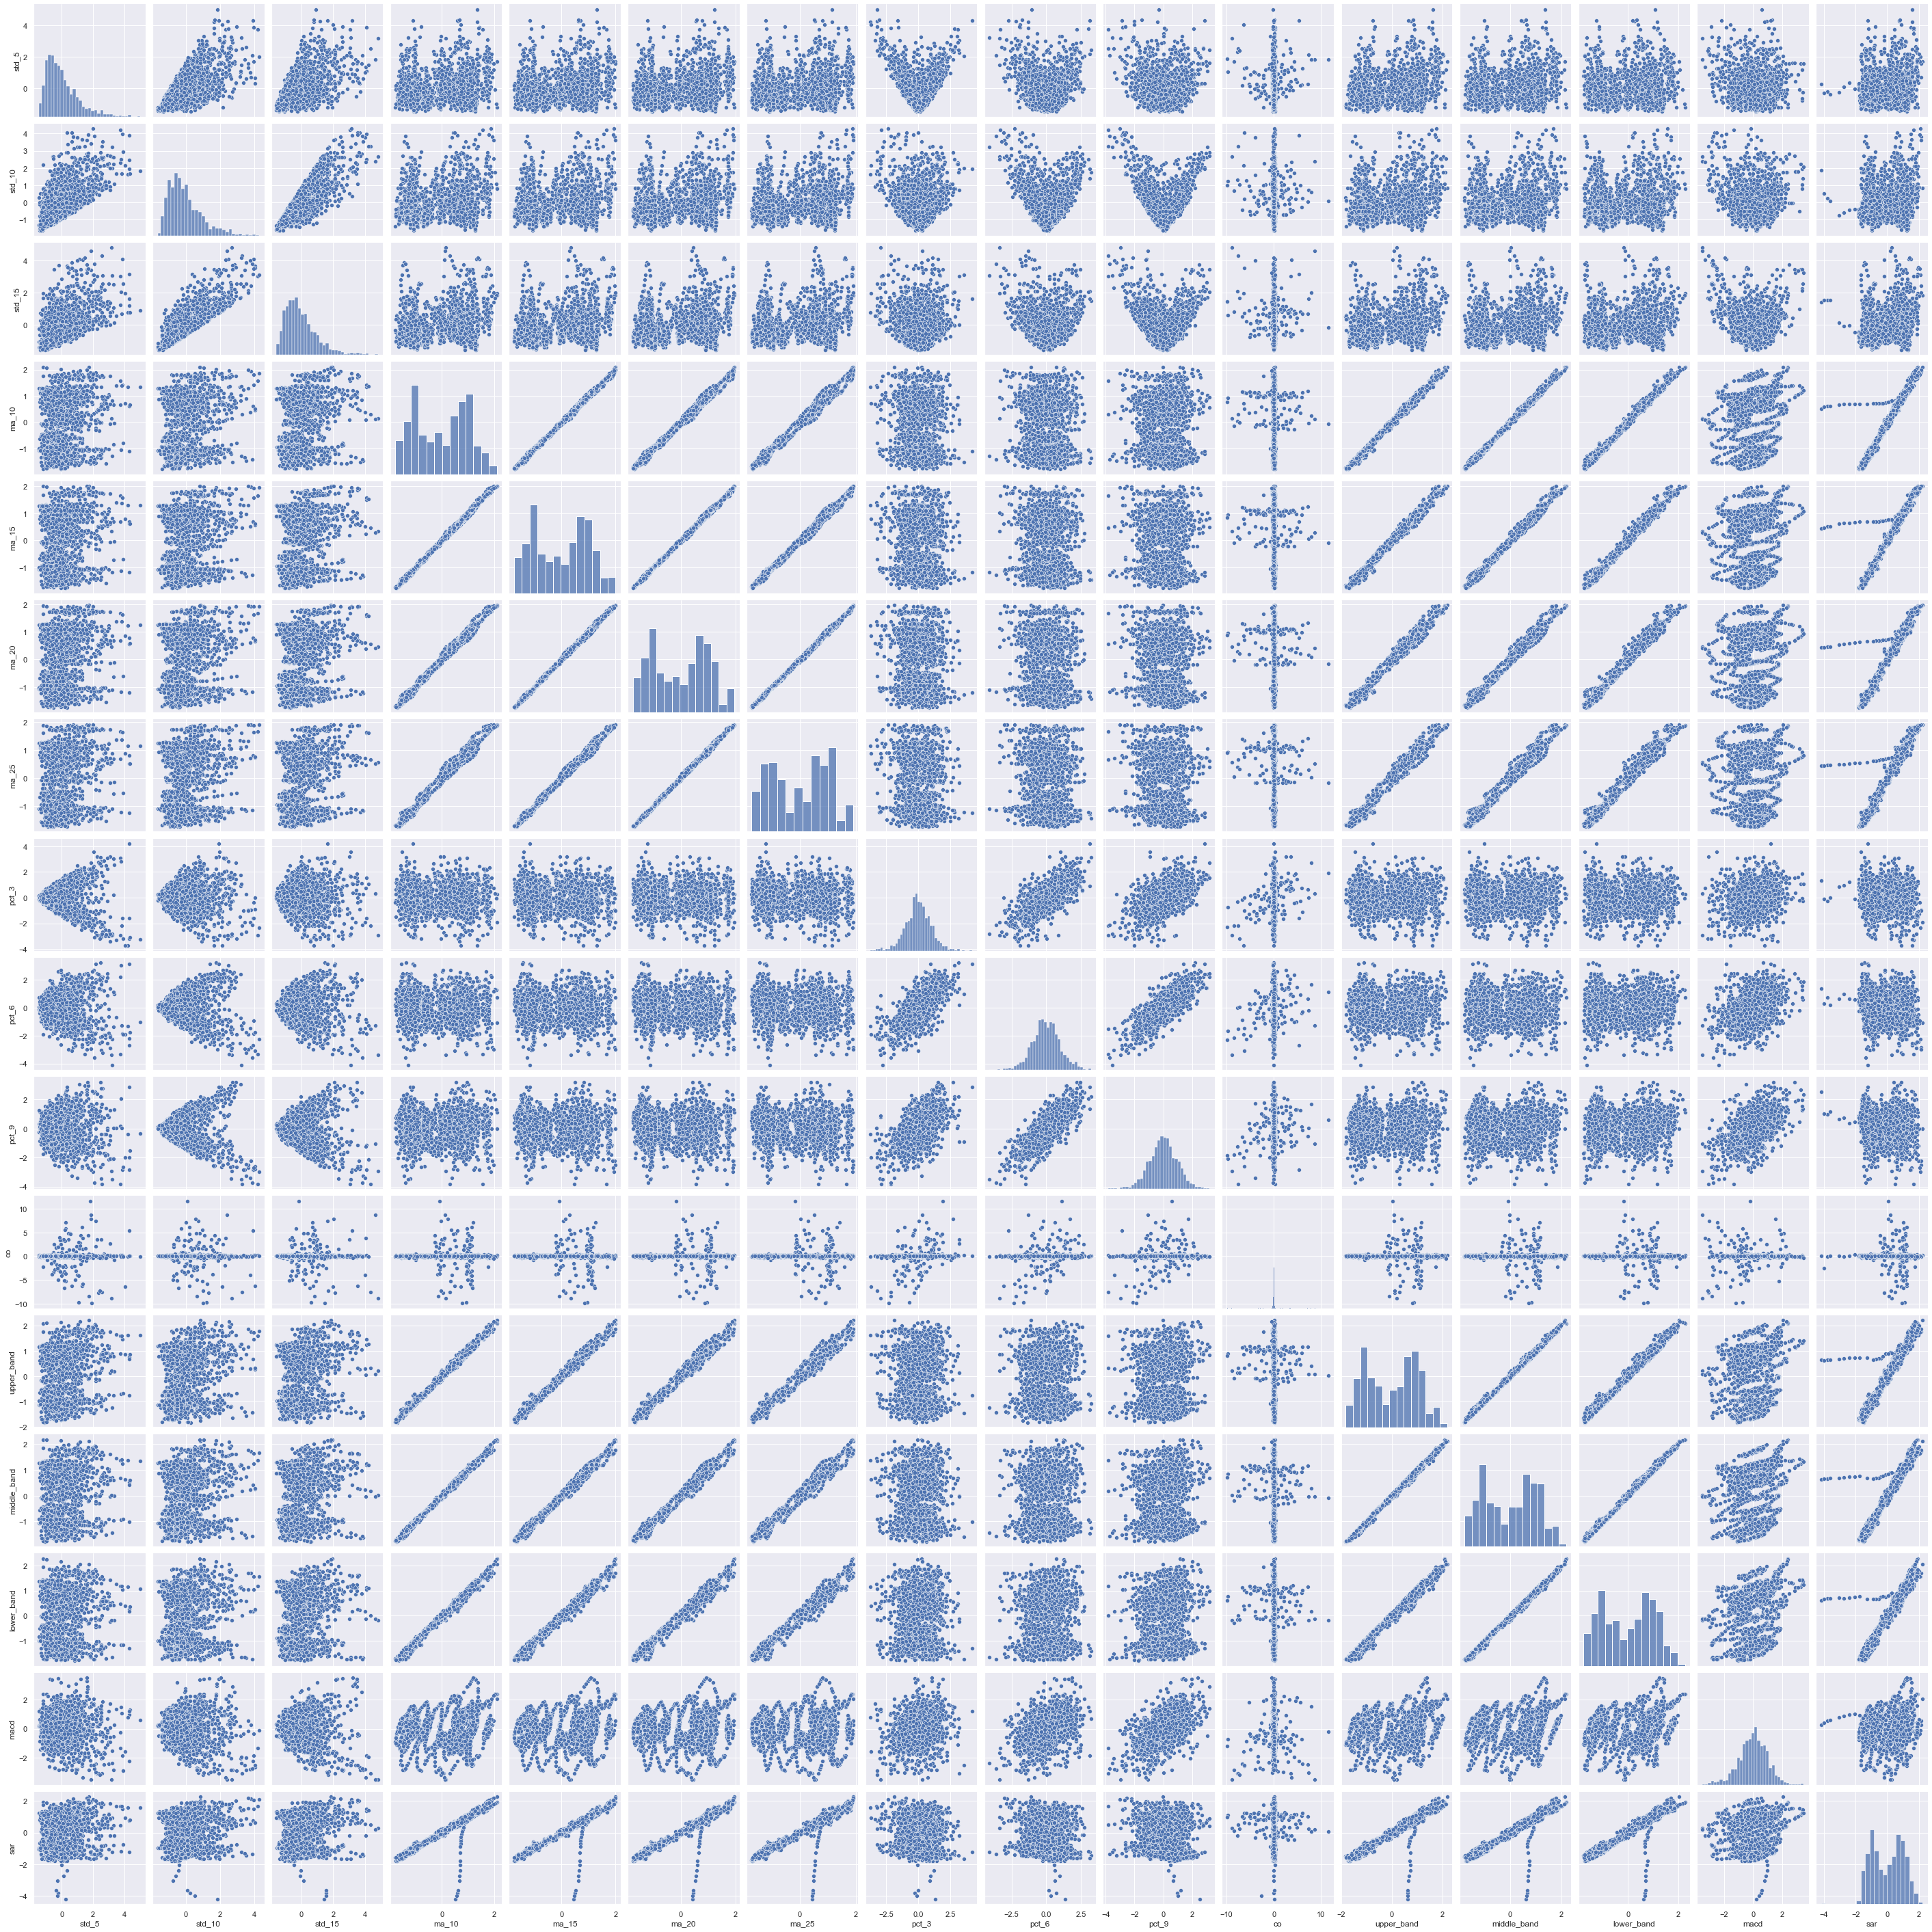

In [18]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
sns.pairplot(X_train_scaled_df[features_list]);

In [19]:
X_train_scaled_df.describe().round(2)

std_5   std_10   std_15    ma_10    ma_15    ma_20    ma_25    pct_3  \
count  1848.00  1848.00  1848.00  1848.00  1848.00  1848.00  1848.00  1848.00   
mean     -0.00    -0.00    -0.00    -0.00     0.00    -0.00    -0.00    -0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min      -1.47    -1.64    -1.56    -1.78    -1.76    -1.74    -1.72    -3.74   
25%      -0.73    -0.74    -0.71    -0.99    -1.00    -1.01    -1.02    -0.59   
50%      -0.23    -0.21    -0.21     0.07     0.07     0.10     0.10    -0.01   
75%       0.49     0.50     0.48     0.85     0.85     0.85     0.85     0.62   
max       5.02     4.29     4.81     2.10     2.00     1.96     1.91     4.21   

         pct_6    pct_9       co  upper_band  middle_band  lower_band  \
count  1848.00  1848.00  1848.00     1848.00      1848.00     1848.00   
mean     -0.00     0.00    -0.00        0.00        -0.00        0.00   
std       1.00     1.00     1.00        1.00         1.00        1.00   
min      -4.10    -3.82    -9.92       -1.82        -1.78       -1.79   
25%      -0.60    -0.61    -0.03       -0.97        -0.98       -0.98   
50%      -0.01     0.01     0.01        0.08         0.06        0.07   
75%       0.63     0.63     0.06        0.85         0.86        0.87   
max       3.22     3.21    11.60        2.20         2.18        2.27   

          macd      sar  
count  1848.00  1848.00  
mean      0.00    -0.00  
std       1.00     1.00  
min      -3.51    -4.19  
25%      -0.57    -0.91  
50%       0.05     0.07  
75%       0.66     0.85  
max       3.49     2.24

We have everything ready now. Now is the time to create our first neural network. We'll use the `MLPClassifier` from the `sklearn.neural_network` package. Here, MLP stands for Multi Layer Perceptron. A simple neural network is shown below:

![Neural Network](https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-diagram-600x400.jpg)

We can see that a neural network consists of

- Input layer,
- Hidden layer, and 
- Output layer

Hence, we need to define these layers for the model. In our case, the feature matrix `X` becomes input to the input layer. Then we have hidden layer/s and finally the output layer. In the above diagram, we have only one hidden layer.

    Note: In `sklearn` library, we need not specify the size of the input and output layer. It will be fixed by the library itself when we train it. Hence, we are only to define hidden layer sizes.

Below we define the model:

In [20]:
from sklearn.neural_network import MLPClassifier

In [21]:
# Define model
model = MLPClassifier(hidden_layer_sizes=(5), verbose=True, random_state=10)

# Train model
model.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.76688016
Iteration 2, loss = 0.74869301
Iteration 3, loss = 0.73583960
Iteration 4, loss = 0.72599865
Iteration 5, loss = 0.71896752
Iteration 6, loss = 0.71399469
Iteration 7, loss = 0.71022536
Iteration 8, loss = 0.70716805
Iteration 9, loss = 0.70502794
Iteration 10, loss = 0.70311081
Iteration 11, loss = 0.70166266
Iteration 12, loss = 0.70049239
Iteration 13, loss = 0.69962605
Iteration 14, loss = 0.69878464
Iteration 15, loss = 0.69802555
Iteration 16, loss = 0.69730014
Iteration 17, loss = 0.69656519
Iteration 18, loss = 0.69606038
Iteration 19, loss = 0.69549813
Iteration 20, loss = 0.69516348
Iteration 21, loss = 0.69471418
Iteration 22, loss = 0.69435153
Iteration 23, loss = 0.69408957
Iteration 24, loss = 0.69384147
Iteration 25, loss = 0.69363954
Iteration 26, loss = 0.69345353
Iteration 27, loss = 0.69315362
Iteration 28, loss = 0.69285053
Iteration 29, loss = 0.69270394
Iteration 30, loss = 0.69241955
Iteration 31, loss = 0.69217949
Iteration 32, los

MLPClassifier(hidden_layer_sizes=5, random_state=10, verbose=True)

Congratulations, we have successfully trained our first neural network. Now let's check its properties

In [22]:
# Check number of layers in the model
model.n_layers_

3

In [24]:
model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 5,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 10,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': True,
 'warm_start': False}

In [34]:
# Check weights
print('Weights between input layer and the hidden layer:')
print(model.coefs_[0])
print('Biases between input layer and the hidden layer:')
print(model.intercepts_[0])

Weights between input layer and the hidden layer:
[[ 0.33714983 -0.48868255  0.16188464  0.40783695  0.02131183]
 [-0.33384171 -0.3014313   0.33347592 -0.29196462 -0.4414856 ]
 [ 0.09135832  0.3534536  -0.44577073  0.07725498  0.41011315]
 [ 0.0923903   0.15046154 -0.27008316  0.51414087  0.28810862]
 [ 0.01675489 -0.47129166 -0.18217121  0.25288487 -0.00886987]
 [-0.1155769   0.03458268 -0.04359813  0.23799906  0.171958  ]
 [ 0.27799276 -0.06753023  0.37730197 -0.1098392  -0.36133965]
 [-0.07272573 -0.52759797  0.2232191  -0.39560552  0.0577803 ]
 [ 0.1481608   0.41220623 -0.3862982   0.4842509  -0.35056338]
 [ 0.22759414 -0.18086442  0.20519106 -0.14783783 -0.31371988]
 [-0.06077056 -0.34429876  0.02545407 -0.5730231  -0.15706524]
 [ 0.45183709  0.43661687 -0.10178741  0.42755314 -0.20583082]
 [ 0.0760983   0.34445259 -0.02019827  0.17000694 -0.43249068]
 [-0.18565386 -0.53701817 -0.26705901 -0.1129129   0.35254292]
 [-0.24380338  0.02301324 -0.06350159 -0.09305777 -0.36908589]
 [-0.

In [35]:
print('Weights between hidden layer and the output layer:')
print(model.coefs_[1])
print('Biases between hidden layer and the output layer:')
print(model.intercepts_[1])

Weights between hidden layer and the output layer:
[[-0.74236362]
 [-0.35820982]
 [-0.31535596]
 [ 0.18338416]
 [ 0.22369228]]
Biases between hidden layer and the output layer:
[0.03930253]


In [36]:
# Check model accuracy on training data
print('Model accuracy on training data:', model.score(X_train_scaled, y_train))

Model accuracy on training data: 0.5275974025974026


In [26]:
# Check model accuracy on testing data
print('Model accuracy on testing data:', model.score(X_test_scaled, y_test))

Model accuracy on testing data: 0.48268398268398266


In [27]:
X_train_scaled

array([[-0.24766138, -0.98622026, -0.11427083, ...,  0.43215371,
        -1.325187  ,  0.48078134],
       [ 0.08341549, -0.45806669, -0.48086929, ..., -0.71190819,
        -1.29576633, -0.76705978],
       [ 0.89982344,  2.17423692,  2.58690108, ..., -1.10301794,
        -2.84445321, -0.8519329 ],
       ...,
       [-0.88851159,  0.09331339, -0.25693029, ...,  1.23381608,
         0.80883507,  1.07565451],
       [-0.805351  ,  0.15498999,  1.75371365, ..., -1.31420301,
        -0.22606969, -1.3647514 ],
       [-0.32770352, -0.99188363, -0.44212387, ...,  1.17616296,
         0.67775504,  1.19070528]])

In [28]:
model.predict_proba(X_test_scaled)

array([[0.53183713, 0.46816287],
       [0.51495224, 0.48504776],
       [0.50899335, 0.49100665],
       [0.48272202, 0.51727798],
       [0.56027137, 0.43972863],
       [0.50505373, 0.49494627],
       [0.34542015, 0.65457985],
       [0.4812372 , 0.5187628 ],
       [0.48872213, 0.51127787],
       [0.4888386 , 0.5111614 ],
       [0.47766439, 0.52233561],
       [0.56812633, 0.43187367],
       [0.42822075, 0.57177925],
       [0.46141836, 0.53858164],
       [0.55797213, 0.44202787],
       [0.49262241, 0.50737759],
       [0.51619814, 0.48380186],
       [0.52303867, 0.47696133],
       [0.47248301, 0.52751699],
       [0.59484424, 0.40515576],
       [0.37292866, 0.62707134],
       [0.40688346, 0.59311654],
       [0.45019467, 0.54980533],
       [0.41519248, 0.58480752],
       [0.51938088, 0.48061912],
       [0.50941101, 0.49058899],
       [0.49714354, 0.50285646],
       [0.77290657, 0.22709343],
       [0.41459312, 0.58540688],
       [0.51490258, 0.48509742],
       [0.

As training and testing accuracy are very similar, we can consider that model might not have overfitted, and it may generalize well. However, it is difficult to claim until we evaluate the model properly.

Also, the model that we have created is a very simple one; we have used most of the default parameters for building the model. And they might not be the best one. 

## Part 2 - Backtesting our predictions

So far we've covered
* Read Data
* Create Features
* Scale data
* Use already trained model to make predictions
* Trade on those prediction, and calculate the strategy returns

In [29]:
def backtest(df, model):
    # Copy data
    data = df.copy()
    
    # Create returns
    data['returns'] = np.log(data['Close'] / data['Close'].shift(1))
    # Creating features
    features_list = []

    # SD based features
    for i in range(5, 20, 5):
        col_name = 'std_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).std()
        features_list.append(col_name)

    # MA based features
    for i in range(10, 30, 5):
        col_name = 'ma_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).mean()
        features_list.append(col_name)

    # Daily pct change based features
    for i in range(3, 12, 3):
        col_name = 'pct_' + str(i)
        data[col_name] = data['Close'].pct_change().rolling(i).sum()
        features_list.append(col_name)

    # Intraday movement
    col_name = 'co'
    data[col_name] = data['Close'] - data['Open']
    features_list.append(col_name)
    # Create features
    data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data['Close'].values)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'].values)
    data['sar'] = ta.SAR(data['High'].values, data['Low'].values)
    features_list +=['upper_band','middle_band','lower_band','macd','sar']
    # Create target
    data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    
    # Drop null values
    data.dropna(inplace=True)
    
    # Create feature matrix and target vector
    X = data[features_list]
    y = data['target']
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Predict
    y_pred = model.predict(X_scaled)
    
    data['predicted'] = y_pred
    
    # Create strategy returns
    data['strategy_returns'] = data['returns'].shift(-1) * data['predicted']
    
    # Return the last cumulative return
    bnh_returns = data['returns'].cumsum()[-1]
    
    # Return the last cumulative strategy return
    # we need to drop the last nan value
    data.dropna(inplace=True)
    strategy_returns = data['strategy_returns'].cumsum()[-1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['returns'].cumsum())
    plt.plot(data['strategy_returns'].cumsum())
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.title('Returns Comparison')
    plt.legend(["Buy and Hold Returns","Strategy Returns"])
    plt.show()
    
    return bnh_returns, strategy_returns, data

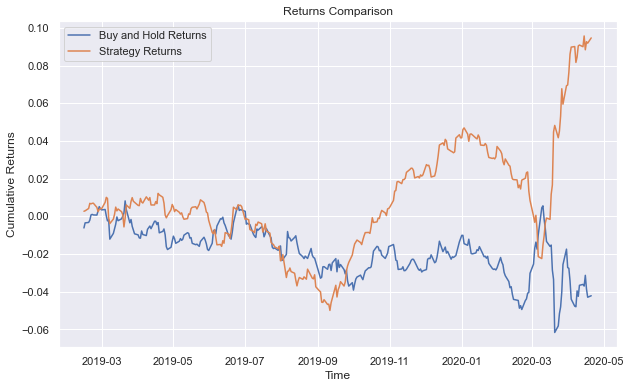

Open      High       Low     Close  Adj Close  Volume  \
Date                                                                    
2019-02-14  1.126405  1.130825  1.125062  1.126494   1.126494       0   
2019-02-15  1.129471  1.129816  1.123495  1.129535   1.129535       0   
2019-02-18  1.129484  1.133414  1.129484  1.129803   1.129803       0   
2019-02-19  1.131209  1.134185  1.127701  1.131196   1.131196       0   
2019-02-20  1.134301  1.136958  1.132593  1.134301   1.134301       0   
...              ...       ...       ...       ...        ...     ...   
2020-04-14  1.091953  1.098394  1.091572  1.092299   1.092299       0   
2020-04-15  1.098237  1.098901  1.085765  1.098539   1.098539       0   
2020-04-16  1.090382  1.090774  1.082966  1.090510   1.090510       0   
2020-04-17  1.086012  1.089325  1.081268  1.085847   1.085847       0   
2020-04-20  1.086626  1.089704  1.084305  1.086697   1.086697       0   

             returns     std_5    std_10    std_15  ...  upper_band  \
Date                                                ...               
2019-02-14 -0.006170  0.003396  0.006916  0.006950  ...    1.136909   
2019-02-15  0.002696  0.002949  0.006553  0.007093  ...    1.135240   
2019-02-18  0.000237  0.002616  0.005572  0.007343  ...    1.134121   
2019-02-19  0.001232  0.002546  0.004294  0.007329  ...    1.134654   
2019-02-20  0.002741  0.002834  0.003144  0.007087  ...    1.135335   
...              ...       ...       ...       ...  ...         ...   
2020-04-14 -0.000885  0.002890  0.006930  0.009959  ...    1.096007   
2020-04-15  0.005696  0.004321  0.006161  0.009447  ...    1.100372   
2020-04-16 -0.007335  0.003017  0.005820  0.009398  ...    1.098867   
2020-04-17 -0.004285  0.004596  0.005742  0.009098  ...    1.100314   
2020-04-20  0.000782  0.005089  0.005048  0.007038  ...    1.099882   

            middle_band  lower_band      macd  macdsignal  macdhist       sar  \
Date                                                                            
2019-02-14     1.130833    1.124758 -0.003854   -0.002584 -0.001270  1.147230   
2019-02-15     1.129965    1.124689 -0.003980   -0.002864 -0.001117  1.145456   
2019-02-18     1.129440    1.124760 -0.004012   -0.003093 -0.000919  1.143260   
2019-02-19     1.130099    1.125543 -0.003880   -0.003251 -0.000630  1.141283   
2019-02-20     1.130266    1.125196 -0.003485   -0.003298 -0.000188  1.139505   
...                 ...         ...       ...         ...       ...       ...   
2020-04-14     1.090838    1.085668 -0.003208   -0.003486  0.000278  1.082478   
2020-04-15     1.092642    1.084913 -0.002411   -0.003271  0.000859  1.083730   
2020-04-16     1.093471    1.088075 -0.002401   -0.003097  0.000696  1.113784   
2020-04-17     1.092092    1.083871 -0.002737   -0.003025  0.000288  1.113168   
2020-04-20     1.090778    1.081675 -0.002901   -0.003000  0.000099  1.111892   

            target  predicted  strategy_returns  
Date                                             
2019-02-14       1          1          0.002696  
2019-02-15       1          1          0.000237  
2019-02-18       1          1          0.001232  
2019-02-19       1          1          0.002741  
2019-02-20       1         -1         -0.000295  
...            ...        ...               ...  
2020-04-14       1          1          0.005696  
2020-04-15      -1          1         -0.007335  
2020-04-16      -1         -1          0.004285  
2020-04-17       1         -1         -0.000782  
2020-04-20      -1         -1          0.002800  

[307 rows x 28 columns]

In [33]:
# Read backtest data
backtest_data = pd.read_csv('EURUSD_backtest.csv', index_col=0, parse_dates=True)
# Backtest the strategy
bnh_returns, s_returns, data = backtest(backtest_data, model)

data

In [27]:
print('Buy and Hold Returns:', bnh_returns)
print('Strategy Returns:', s_returns)

Buy and Hold Returns: -0.044937002315672055
Strategy Returns: 0.09465662352330222
